In [1]:
suppressPackageStartupMessages(library(plyr))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(tibble))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(patchwork))
suppressPackageStartupMessages(library(stringr))
library(parallel)
library(ggpubr)
library(rstatix)



Attaching package: ‘ggpubr’


The following object is masked from ‘package:plyr’:

    mutate



Attaching package: ‘rstatix’


The following objects are masked from ‘package:plyr’:

    desc, mutate


The following object is masked from ‘package:stats’:

    filter




In [2]:
meta_data<-read.csv('/home//jupyter/BRI_Analysis/scRNA/hise_meta_data_2024-01-23_fixed.csv')


In [3]:
selected_celltype<-c('IL1B+ CD14 monocyte','Core CD14 monocyte')
selected_gene<-c("CXCL8", "RASGEF1B", "PTGS2", "BCL2A1", "FCGR3A",
                 "NR4A1", "IL1B", "NLRP3", "TNF", "G0S2", "RBP7")

In [3]:
selected_celltype<-c('IL1B+ CD14 monocyte')
selected_gene<-c("IL1B")

In [39]:
additional_genes <- c("AL133453.1", "VIM", "CEBPB", "S100A4", "S1PR4", "S1PR1")

# Existing data structure
data <- list(
  `SOX4+ naive CD4 T cell` = c("IL27RA", "NPM1", "TSHZ2", "STAT4", "ID2", "LSP1"),
  `SOX4+ naive CD8 T cell` = c("IL27RA", "NPM1", "TSHZ2", "STAT4"),
  `Core naive CD4 T cell` = c("IL27RA", "NPM1", "TSHZ2", "STAT4", "ID2", "LSP1", "RUNX2", "TIGIT", "LTB", "FOXP1", "KLF6"),
  `Core Naive CD8 T cell` = c("ID2", "LSP1", "RUNX2"),
  `Naive CD4 Treg` = c("TIGIT", "LTB", "FOXP1", "KLF6"),
  `CM CD4 T cell` = c("APOBEC3G", "FOXP1", "ORAI1", "STAT4"),
  `CM CD8 T cell` = c("APOBEC3G", "FOXP1", "ORAI1"),
  `GZMB- CD27- EM CD4 T cell` = c("IL7R", "HIF1A", "MYC"),
  `GZMB- CD27+ EM CD4 T cell` = c("KLRB1", "LSP1"),
  `GZMK+ CD27+ EM CD8 T cell` = c("GZMK", "FYB1")
)

data <- lapply(data, function(x) c(x, additional_genes))

In [17]:
df_list<-mclapply(meta_data$pbmc_sample_id,function(i){
df<-read.csv(paste0('/home//jupyter/BRI_Analysis/scRNA/Average_Expression_by_Celltype_and_Sample/',i,'_AIFI_L3.csv'),
             check.names = FALSE, row.names=1)
selected_celltype<-intersect(colnames(df),selected_celltype)
df_subset<-df[selected_gene,selected_celltype,drop = FALSE]
df_subset$pbmc_sample_id<-i
df_subset$Gene<-selected_gene
df_subset<-   pivot_longer(df_subset, 
                        cols = -c(pbmc_sample_id,Gene), 
                        names_to = "AIFI_L3",  
                        values_to = "Mean_Expression") 
return(df_subset)
},mc.cores=60)

In [18]:
mean_df<-do.call(rbind, df_list)

In [19]:
mean_df<-left_join(mean_df,meta_data)

Joining with `by = join_by(pbmc_sample_id)`


In [20]:
mean_df<-mean_df[!is.na(mean_df$X),]

In [21]:
mean_df$Group=paste0(mean_df$cohort.cohortGuid,'-',mean_df$subject.biologicalSex)

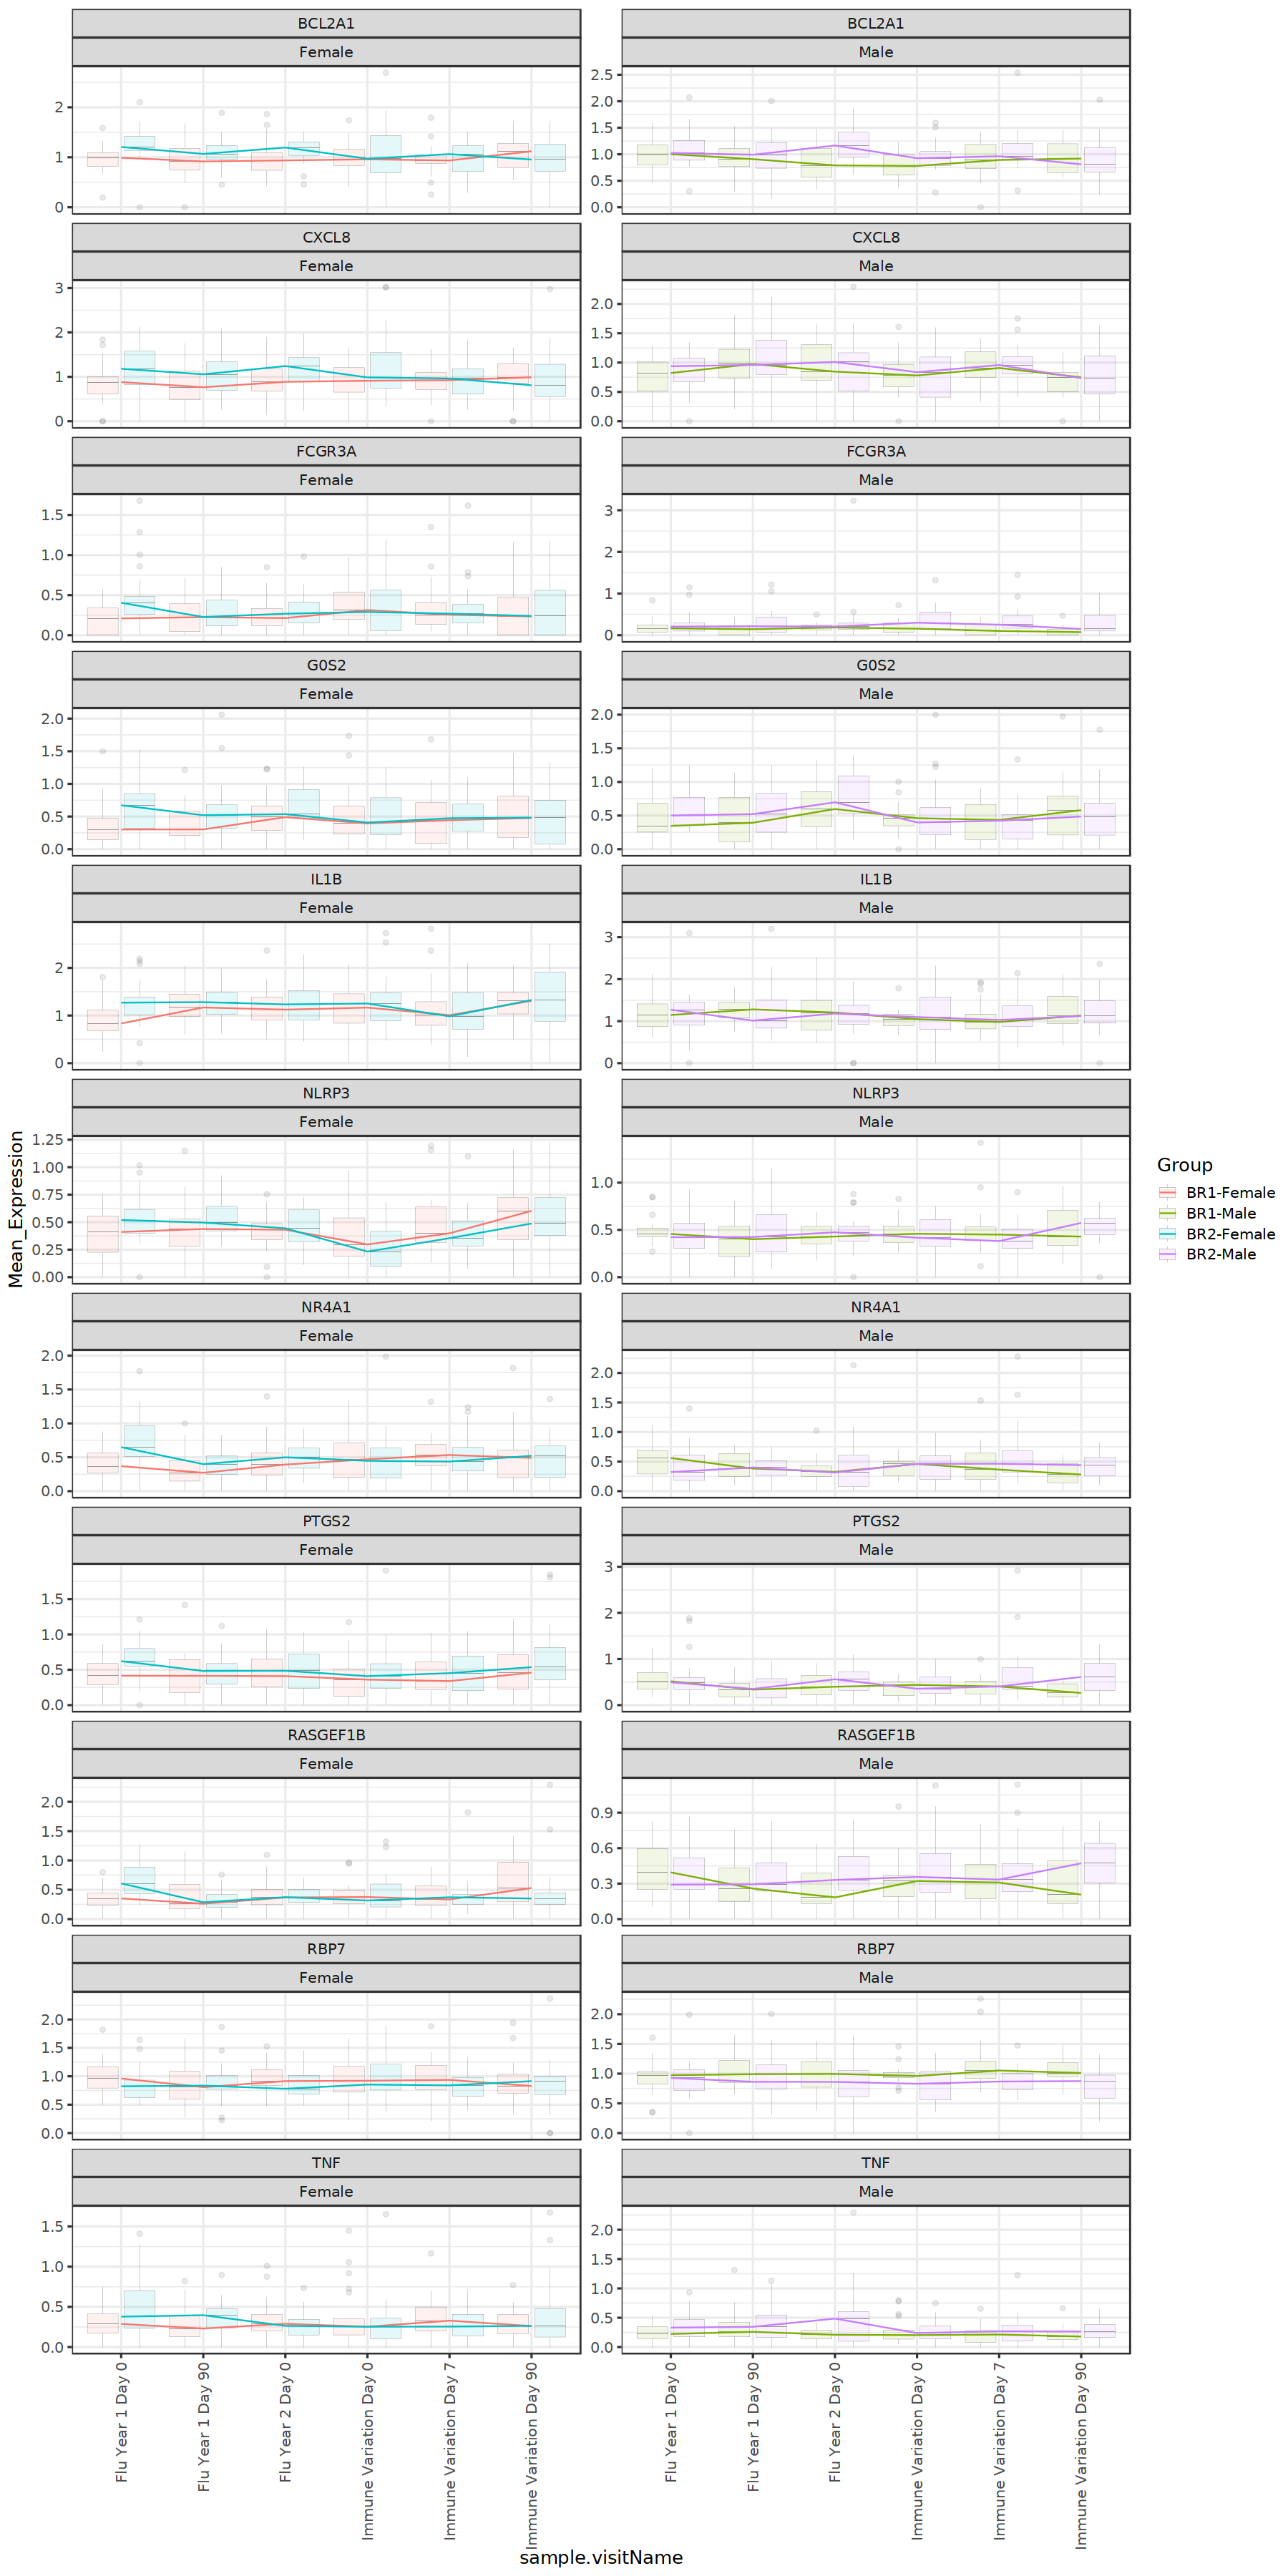

In [29]:
options(repr.plot.width = 15, repr.plot.height = 30)

ggplot(mean_df %>% 
       filter(!sample.visitName %in% c('Flu Year 1 Day 7','Flu Year 2 Day 7',
                                       'Flu Year 1 Stand-Alone','Flu Year 2 Day 90',
                                                   'Flu Year 2 Stand-Alone',
                                                   'Flu Year 3 Stand-Alone'))%>% 
       filter(AIFI_L3 %in% c('IL1B+ CD14 monocyte')), 
       aes(x = sample.visitName, y = Mean_Expression, fill = Group)) +
  geom_boxplot(position = position_dodge(width = 0.9),size=0.05,alpha=0.1) +
  stat_summary(
    fun.y = median,
    geom = 'line',
    aes(group =Group, colour = Group),#position = position_dodge(width = 0.9)
     )+theme_bw(base_size=15)+ 
theme(axis.text.x = element_text(angle = 90, 
                                 vjust = 0.5, 
                                 hjust=1))+
facet_wrap(~Gene+subject.biologicalSex,scale='free_y',
            ncol=2)


In [22]:
mean_df$Mean_Expression<-as.numeric(mean_df$Mean_Expression)

`geom_smooth()` using formula = 'y ~ x'


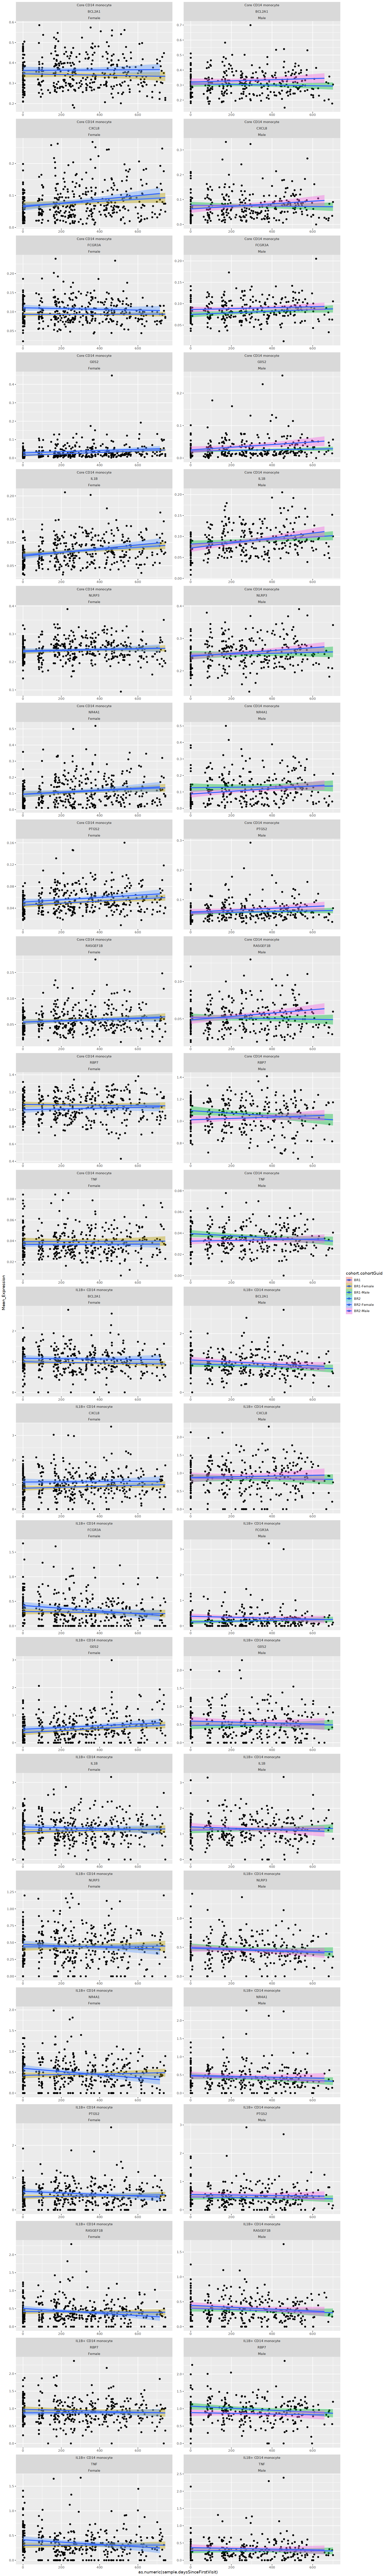

In [34]:
options(repr.plot.width = 15, repr.plot.height = 100)

ggplot(mean_df %>% filter(sample.daysSinceFirstVisit<750)%>% 
filter(!sample.visitName %in% c('Flu Year 1 Day 7','Flu Year 2 Day 7')), 
       aes(x=as.numeric(sample.daysSinceFirstVisit), y = Mean_Expression, fill = cohort.cohortGuid)) +
  geom_point() + 
  geom_smooth(method=lm, aes(fill=Group))+facet_wrap(~AIFI_L3+Gene+subject.biologicalSex,scale='free',ncol=2)


# T cells

In [4]:
plot_function <- function(mean_df) {
  ggplot(mean_df %>% 
           filter(sample.daysSinceFirstVisit < 750) %>% 
           filter(!sample.visitName %in% c('Flu Year 1 Day 7', 'Flu Year 2 Day 7')),
         aes(x = as.numeric(sample.daysSinceFirstVisit), 
             y = Mean_Expression, 
             fill = cohort.cohortGuid)) +
    geom_point() +
    geom_smooth(method = lm, aes(fill = cohort.cohortGuid)) +
    facet_wrap(~AIFI_L3 + Gene, scale = 'free', ncol = 4)
}

In [5]:

data <- list(
  `SOX4+ naive CD4 T cell` = c("IL27RA", "NPM1", "TSHZ2", "STAT4", "ID2", "LSP1"),
  `SOX4+ naive CD8 T cell` = c("IL27RA", "NPM1", "TSHZ2", "STAT4"),
  `Core naive CD4 T cell` = c("IL27RA", "NPM1", "TSHZ2", "STAT4", "ID2", "LSP1", "RUNX2", "TIGIT", "LTB", "FOXP1", "KLF6"),
  `Core naive CD8 T cell ` = c("ID2", "LSP1", "RUNX2"),
  `Naive CD4 Treg` = c("TIGIT", "LTB", "FOXP1", "KLF6"),
  `CM CD4 T cell` = c("APOBEC3G", "FOXP1", "ORAI1", "STAT4"),
  `CM CD8 T cell` = c("APOBEC3G", "FOXP1", "ORAI1"),
  `GZMB- CD27- EM CD4 T cell` = c("IL7R", "HIF1A", "MYC"),
  `GZMB- CD27+ EM CD4 T cell` = c("KLRB1", "LSP1"),
  `GZMK+ CD27+ EM CD8 T cell` = c("GZMK", "FYB1")
)
additional_genes_all <- c("AL133453.1", "VIM", "CEBPB", "S100A4", "S1PR4", "S1PR1",'LGALS1')

data <- lapply(data, function(x) c(x, additional_genes_all))

In [6]:
for (selected_celltype in names(data)){

selected_celltype<-selected_celltype
selected_gene<-data[selected_celltype]
    print(selected_celltype)
    print(selected_gene)
df_list<-mclapply(meta_data$pbmc_sample_id,function(X){
df<-read.csv(paste0('/home//jupyter/BRI_Analysis/scRNA/Average_Expression_by_Celltype_and_Sample/',X,'_AIFI_L3.csv'),
             check.names = FALSE, row.names=1)
selected_celltype<-intersect(colnames(df),selected_celltype)
df_subset<-df[unname(selected_gene)[[1]],selected_celltype,drop = FALSE]
df_subset$pbmc_sample_id<-X
df_subset$Gene<-rownames(df_subset)

df_subset<-   pivot_longer(df_subset, 
                        cols = -c(pbmc_sample_id,Gene), 
                        names_to = "AIFI_L3",  
                        values_to = "Mean_Expression") 
return(df_subset)
},mc.cores=60)

mean_df<-do.call(rbind, df_list)
mean_df<-left_join(mean_df,meta_data)
mean_df<-mean_df[!is.na(mean_df$X),]
mean_df$Mean_Expression<-as.numeric(mean_df$Mean_Expression)
pdf(paste0(selected_celltype,".pdf"), width = 30, height = 20)

print(plot_function(mean_df))
dev.off()
}


[1] "SOX4+ naive CD4 T cell"
$`SOX4+ naive CD4 T cell`
 [1] "IL27RA"     "NPM1"       "TSHZ2"      "STAT4"      "ID2"       
 [6] "LSP1"       "AL133453.1" "VIM"        "CEBPB"      "S100A4"    
[11] "S1PR4"      "S1PR1"      "LGALS1"    



Warning message in mclapply(meta_data$pbmc_sample_id, function(X) {:
“scheduled cores 15, 18, 26, 7, 9, 8, 54, 45, 58, 42, 1, 41, 23, 4, 17, 28, 20, 5, 44, 12, 38, 51, 33, 14, 39, 22 encountered errors in user code, all values of the jobs will be affected”
Joining with `by = join_by(pbmc_sample_id)`
`geom_smooth()` using formula = 'y ~ x'


[1] "SOX4+ naive CD8 T cell"
$`SOX4+ naive CD8 T cell`
 [1] "IL27RA"     "NPM1"       "TSHZ2"      "STAT4"      "AL133453.1"
 [6] "VIM"        "CEBPB"      "S100A4"     "S1PR4"      "S1PR1"     
[11] "LGALS1"    



Warning message in mclapply(meta_data$pbmc_sample_id, function(X) {:
“scheduled cores 30, 9, 38, 21, 28, 37, 43, 6, 15, 26, 41, 18, 24, 11, 12, 32, 51, 10, 7, 8, 3, 56, 44, 53, 4, 33, 47, 50, 57, 58, 27, 2, 45, 20, 59, 34, 1, 54, 23, 52, 42, 17, 35, 19, 5, 13, 48, 16, 14, 39 encountered errors in user code, all values of the jobs will be affected”
Joining with `by = join_by(pbmc_sample_id)`
`geom_smooth()` using formula = 'y ~ x'


[1] "Core naive CD4 T cell"
$`Core naive CD4 T cell`
 [1] "IL27RA"     "NPM1"       "TSHZ2"      "STAT4"      "ID2"       
 [6] "LSP1"       "RUNX2"      "TIGIT"      "LTB"        "FOXP1"     
[11] "KLF6"       "AL133453.1" "VIM"        "CEBPB"      "S100A4"    
[16] "S1PR4"      "S1PR1"      "LGALS1"    



Joining with `by = join_by(pbmc_sample_id)`
`geom_smooth()` using formula = 'y ~ x'


[1] "Core naive CD8 T cell "
$`Core naive CD8 T cell `
 [1] "ID2"        "LSP1"       "RUNX2"      "AL133453.1" "VIM"       
 [6] "CEBPB"      "S100A4"     "S1PR4"      "S1PR1"      "LGALS1"    



Joining with `by = join_by(pbmc_sample_id)`
`geom_smooth()` using formula = 'y ~ x'


[1] "Naive CD4 Treg"
$`Naive CD4 Treg`
 [1] "TIGIT"      "LTB"        "FOXP1"      "KLF6"       "AL133453.1"
 [6] "VIM"        "CEBPB"      "S100A4"     "S1PR4"      "S1PR1"     
[11] "LGALS1"    



Joining with `by = join_by(pbmc_sample_id)`
`geom_smooth()` using formula = 'y ~ x'


[1] "CM CD4 T cell"
$`CM CD4 T cell`
 [1] "APOBEC3G"   "FOXP1"      "ORAI1"      "STAT4"      "AL133453.1"
 [6] "VIM"        "CEBPB"      "S100A4"     "S1PR4"      "S1PR1"     
[11] "LGALS1"    



Joining with `by = join_by(pbmc_sample_id)`
`geom_smooth()` using formula = 'y ~ x'


[1] "CM CD8 T cell"
$`CM CD8 T cell`
 [1] "APOBEC3G"   "FOXP1"      "ORAI1"      "AL133453.1" "VIM"       
 [6] "CEBPB"      "S100A4"     "S1PR4"      "S1PR1"      "LGALS1"    



Joining with `by = join_by(pbmc_sample_id)`
`geom_smooth()` using formula = 'y ~ x'


[1] "GZMB- CD27- EM CD4 T cell"
$`GZMB- CD27- EM CD4 T cell`
 [1] "IL7R"       "HIF1A"      "MYC"        "AL133453.1" "VIM"       
 [6] "CEBPB"      "S100A4"     "S1PR4"      "S1PR1"      "LGALS1"    



Joining with `by = join_by(pbmc_sample_id)`
`geom_smooth()` using formula = 'y ~ x'


[1] "GZMB- CD27+ EM CD4 T cell"
$`GZMB- CD27+ EM CD4 T cell`
[1] "KLRB1"      "LSP1"       "AL133453.1" "VIM"        "CEBPB"     
[6] "S100A4"     "S1PR4"      "S1PR1"      "LGALS1"    



Joining with `by = join_by(pbmc_sample_id)`
`geom_smooth()` using formula = 'y ~ x'


[1] "GZMK+ CD27+ EM CD8 T cell"
$`GZMK+ CD27+ EM CD8 T cell`
[1] "GZMK"       "FYB1"       "AL133453.1" "VIM"        "CEBPB"     
[6] "S100A4"     "S1PR4"      "S1PR1"      "LGALS1"    



Joining with `by = join_by(pbmc_sample_id)`
`geom_smooth()` using formula = 'y ~ x'


In [7]:
plot_function <- function(mean_df) {
  ggplot(mean_df %>% 
           filter(sample.daysSinceFirstVisit < 750) %>% 
           filter(!sample.visitName %in% c('Flu Year 1 Day 7', 'Flu Year 2 Day 7')),
         aes(x = as.numeric(sample.daysSinceFirstVisit), 
             y = Mean_Expression, 
             fill = cohort.cohortGuid)) +
    geom_point() +
    geom_smooth(method = lm, aes(fill = cohort.cohortGuid)) +
    facet_wrap(~AIFI_L3 + Gene, scale = 'free', ncol = 4)
}

`geom_smooth()` using formula = 'y ~ x'


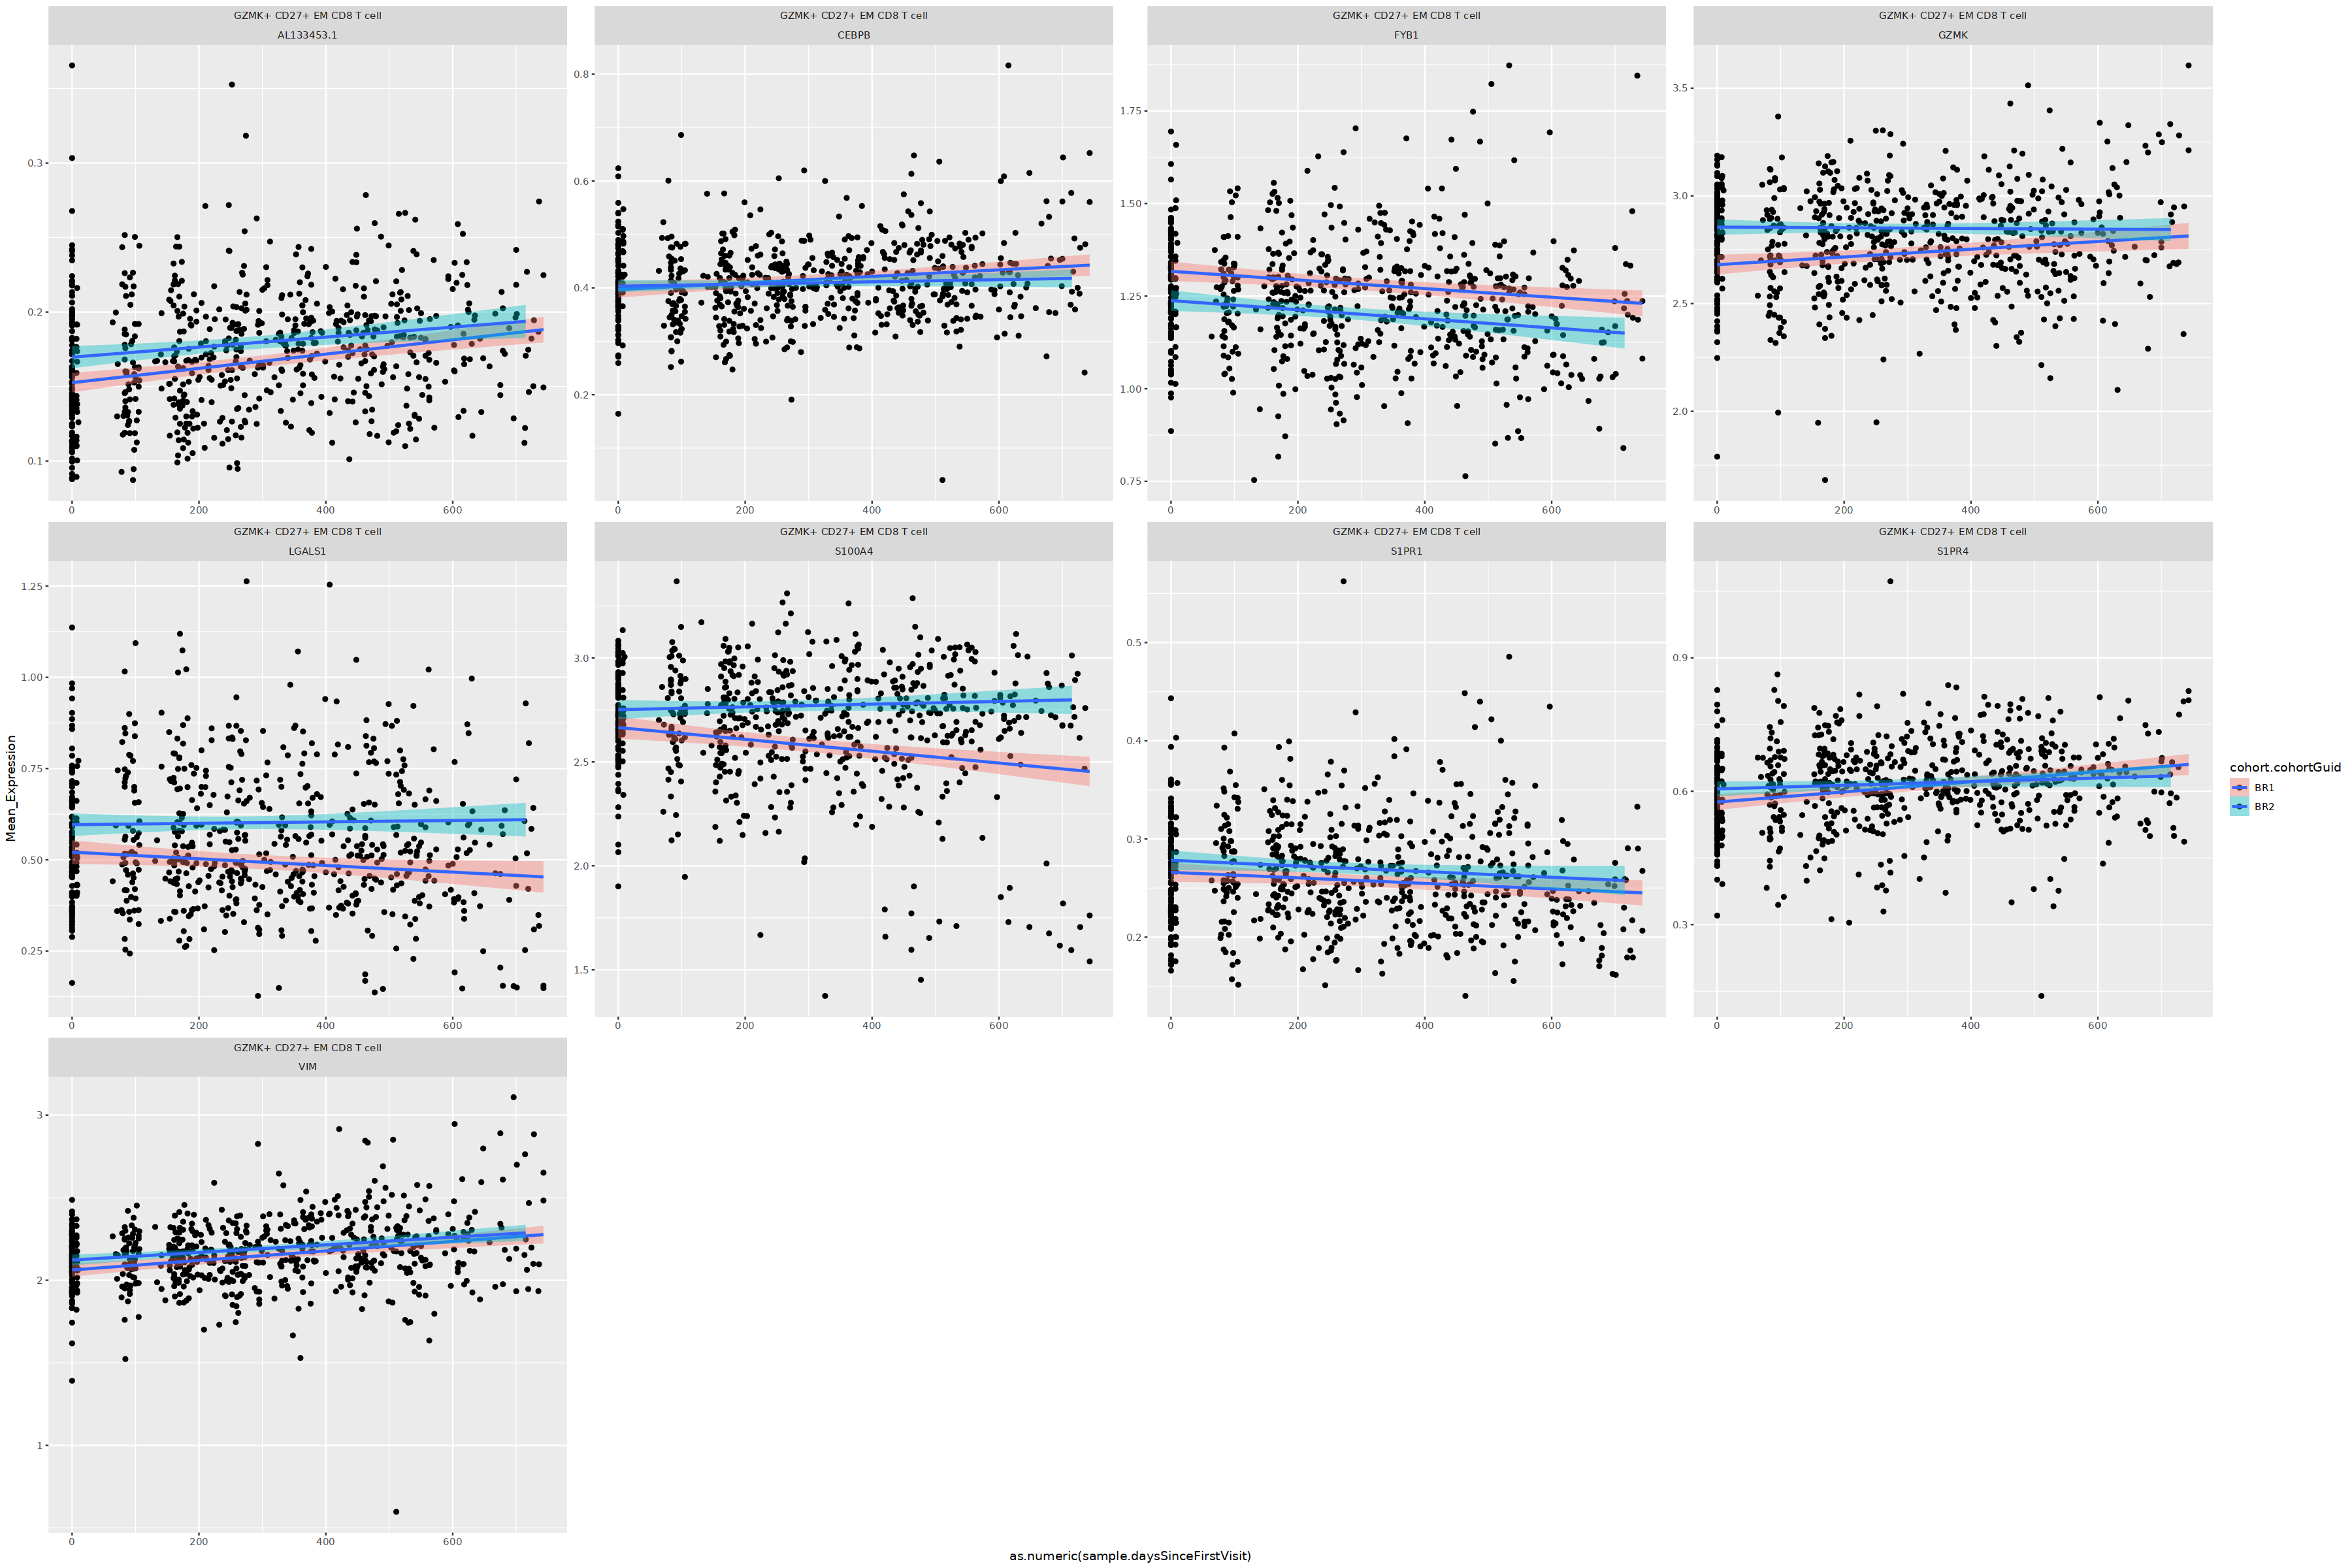

In [8]:
options(repr.plot.width = 30, repr.plot.height = 20)

ggplot(mean_df %>% filter(sample.daysSinceFirstVisit<750)%>% 
filter(!sample.visitName %in% c('Flu Year 1 Day 7','Flu Year 2 Day 7')), 
       aes(x=as.numeric(sample.daysSinceFirstVisit), y = Mean_Expression, fill = cohort.cohortGuid)) +
  geom_point() + 
  geom_smooth(method=lm, aes(fill=cohort.cohortGuid))+facet_wrap(~AIFI_L3+Gene,scale='free',ncol=4)


# Paired Test

In [8]:
mean_df_filtered<-mean_df  %>% 
filter(sample.visitName %in% c('Flu Year 1 Day 0','Flu Year 1 Day 90','Flu Year 2 Day 0'))

In [27]:
length(donor_with_paired)

[1] 82

In [9]:
donor_with_paired<-names(table(mean_df_filtered$subject.subjectGuid)[table(mean_df_filtered$subject.subjectGuid)==length(selected_celltype)*length(selected_gene)*3])

In [10]:
mean_df_filtered<-mean_df_filtered%>% filter(subject.subjectGuid %in% donor_with_paired)

In [11]:
head(mean_df_filtered)

pbmc_sample_id Gene     AIFI_L3             Mean_Expression X.2 X.1 X
1 PB00002-01     CXCL8    Core CD14 monocyte  0.14065460      2   2   2
2 PB00002-01     CXCL8    IL1B+ CD14 monocyte 0.32461525      2   2   2
3 PB00002-01     RASGEF1B Core CD14 monocyte  0.02944357      2   2   2
4 PB00002-01     RASGEF1B IL1B+ CD14 monocyte 0.14244522      2   2   2
5 PB00002-01     PTGS2    Core CD14 monocyte  0.05073125      2   2   2
6 PB00002-01     PTGS2    IL1B+ CD14 monocyte 0.34463757      2   2   2
  lastUpdated              sample.id                           
1 2023-11-18T02:03:08.347Z 750e90a9-a296-4f0f-969f-60225c2bca17
2 2023-11-18T02:03:08.347Z 750e90a9-a296-4f0f-969f-60225c2bca17
3 2023-11-18T02:03:08.347Z 750e90a9-a296-4f0f-969f-60225c2bca17
4 2023-11-18T02:03:08.347Z 750e90a9-a296-4f0f-969f-60225c2bca17
5 2023-11-18T02:03:08.347Z 750e90a9-a296-4f0f-969f-60225c2bca17
6 2023-11-18T02:03:08.347Z 750e90a9-a296-4f0f-969f-60225c2bca17
  sample.bridgingControl ⋯ Covid_Dose_1 Covid_Dose_2 Covid_exlcusion
1 false                  ⋯ 2020-12-28   2021-01-18   no             
2 false                  ⋯ 2020-12-28   2021-01-18   no             
3 false                  ⋯ 2020-12-28   2021-01-18   no             
4 false                  ⋯ 2020-12-28   2021-01-18   no             
5 false                  ⋯ 2020-12-28   2021-01-18   no             
6 false                  ⋯ 2020-12-28   2021-01-18   no             
  CMV.IgG.Serology.Result.Interpretation BMI     file.name.downloaded         
1 Negative                               <25-BMI B001-P1_PB00002-01_labeled.h5
2 Negative                               <25-BMI B001-P1_PB00002-01_labeled.h5
3 Negative                               <25-BMI B001-P1_PB00002-01_labeled.h5
4 Negative                               <25-BMI B001-P1_PB00002-01_labeled.h5
5 Negative                               <25-BMI B001-P1_PB00002-01_labeled.h5
6 Negative                               <25-BMI B001-P1_PB00002-01_labeled.h5
  file.path                                                                                                
1 /home/jupyter/BRI_Analysis/scRNA/cache/7c0c7979-eebd-4aba-b5b2-6e76b4643623/B001-P1_PB00002-01_labeled.h5
2 /home/jupyter/BRI_Analysis/scRNA/cache/7c0c7979-eebd-4aba-b5b2-6e76b4643623/B001-P1_PB00002-01_labeled.h5
3 /home/jupyter/BRI_Analysis/scRNA/cache/7c0c7979-eebd-4aba-b5b2-6e76b4643623/B001-P1_PB00002-01_labeled.h5
4 /home/jupyter/BRI_Analysis/scRNA/cache/7c0c7979-eebd-4aba-b5b2-6e76b4643623/B001-P1_PB00002-01_labeled.h5
5 /home/jupyter/BRI_Analysis/scRNA/cache/7c0c7979-eebd-4aba-b5b2-6e76b4643623/B001-P1_PB00002-01_labeled.h5
6 /home/jupyter/BRI_Analysis/scRNA/cache/7c0c7979-eebd-4aba-b5b2-6e76b4643623/B001-P1_PB00002-01_labeled.h5
  Flu_Year Strains_concat                  Group   
1 2019     Phuket+Brisbane+Kansas+Colorado BR1-Male
2 2019     Phuket+Brisbane+Kansas+Colorado BR1-Male
3 2019     Phuket+Brisbane+Kansas+Colorado BR1-Male
4 2019     Phuket+Brisbane+Kansas+Colorado BR1-Male
5 2019     Phuket+Brisbane+Kansas+Colorado BR1-Male
6 2019     Phuket+Brisbane+Kansas+Colorado BR1-Male

In [12]:
STAT_res<-mean_df_filtered %>%
  select(Mean_Expression,Gene, Group,AIFI_L3,subject.subjectGuid,sample.visitName) %>%
  group_by(Gene,AIFI_L3,Group) %>% arrange(subject.subjectGuid, sample.visitName) %>%
  wilcox_test(Mean_Expression ~ sample.visitName, comparisons = list(c("Flu Year 1 Day 0", "Flu Year 1 Day 90"), 
                                                                    c("Flu Year 1 Day 0", "Flu Year 2 Day 0"),
                                                                    c("Flu Year 1 Day 90", "Flu Year 2 Day 0")),paired= TRUE) %>%
  add_xy_position()
head(STAT_res)

Gene   Group      AIFI_L3            .y.             group1           
1 BCL2A1 BR1-Female Core CD14 monocyte Mean_Expression Flu Year 1 Day 0 
2 BCL2A1 BR1-Female Core CD14 monocyte Mean_Expression Flu Year 1 Day 0 
3 BCL2A1 BR1-Female Core CD14 monocyte Mean_Expression Flu Year 1 Day 90
4 BCL2A1 BR1-Male   Core CD14 monocyte Mean_Expression Flu Year 1 Day 0 
5 BCL2A1 BR1-Male   Core CD14 monocyte Mean_Expression Flu Year 1 Day 0 
6 BCL2A1 BR1-Male   Core CD14 monocyte Mean_Expression Flu Year 1 Day 90
  group2            n1 n2 statistic p     p.adj p.adj.signif y.position
1 Flu Year 1 Day 90 23 23 179       0.223 0.446 ns           0.93756   
2 Flu Year 2 Day 0  23 23 122       0.643 0.643 ns           1.51140   
3 Flu Year 2 Day 0  23 23  69       0.035 0.106 ns           2.08524   
4 Flu Year 1 Day 90 15 15  85       0.169 0.507 ns           0.84756   
5 Flu Year 2 Day 0  15 15  60       1.000 1.000 ns           1.42140   
6 Flu Year 2 Day 0  15 15  41       0.303 0.606 ns           1.99524   
  groups            <NA>             <NA>              <NA>             
1 Flu Year 1 Day 0  Flu Year 1 Day 0 Flu Year 1 Day 90 Flu Year 1 Day 0 
2 Flu Year 1 Day 90 Flu Year 2 Day 0 Flu Year 2 Day 0  Flu Year 1 Day 90
3 Flu Year 1 Day 0  Flu Year 1 Day 0 Flu Year 1 Day 90 Flu Year 1 Day 0 
4 Flu Year 1 Day 90 Flu Year 2 Day 0 Flu Year 2 Day 0  Flu Year 1 Day 90
5 Flu Year 1 Day 0  Flu Year 1 Day 0 Flu Year 1 Day 90 Flu Year 1 Day 0 
6 Flu Year 1 Day 90 Flu Year 2 Day 0 Flu Year 2 Day 0  Flu Year 1 Day 90
  <NA>             <NA>              xmin xmax
1 Flu Year 1 Day 0 Flu Year 1 Day 90 1    2   
2 Flu Year 2 Day 0 Flu Year 2 Day 0  1    3   
3 Flu Year 1 Day 0 Flu Year 1 Day 90 2    3   
4 Flu Year 2 Day 0 Flu Year 2 Day 0  1    2   
5 Flu Year 1 Day 0 Flu Year 1 Day 90 1    3   
6 Flu Year 2 Day 0 Flu Year 2 Day 0  2    3

In [13]:
write.csv(as.data.frame(STAT_res),'Stat_Summary.csv')

ERROR: Error in utils::write.table(as.data.frame(STAT_res), "Stat_Summary.csv", : unimplemented type 'list' in 'EncodeElement'



In [ ]:
max_y<-mean_df_filtered %>%
  select(Mean_Expression, AIFI_L3,Group, sample.visitName,Gene) %>%
  distinct() %>%
  group_by(Gene,AIFI_L3,Group,sample.visitName)%>%
  dplyr::summarize(max_exp = max(Mean_Expression)) %>%
  ungroup() %>% arrange(Gene,AIFI_L3,Group) %>% select(max_exp) %>% pull()

In [ ]:
STAT_res$max_y<-max_y*1.1

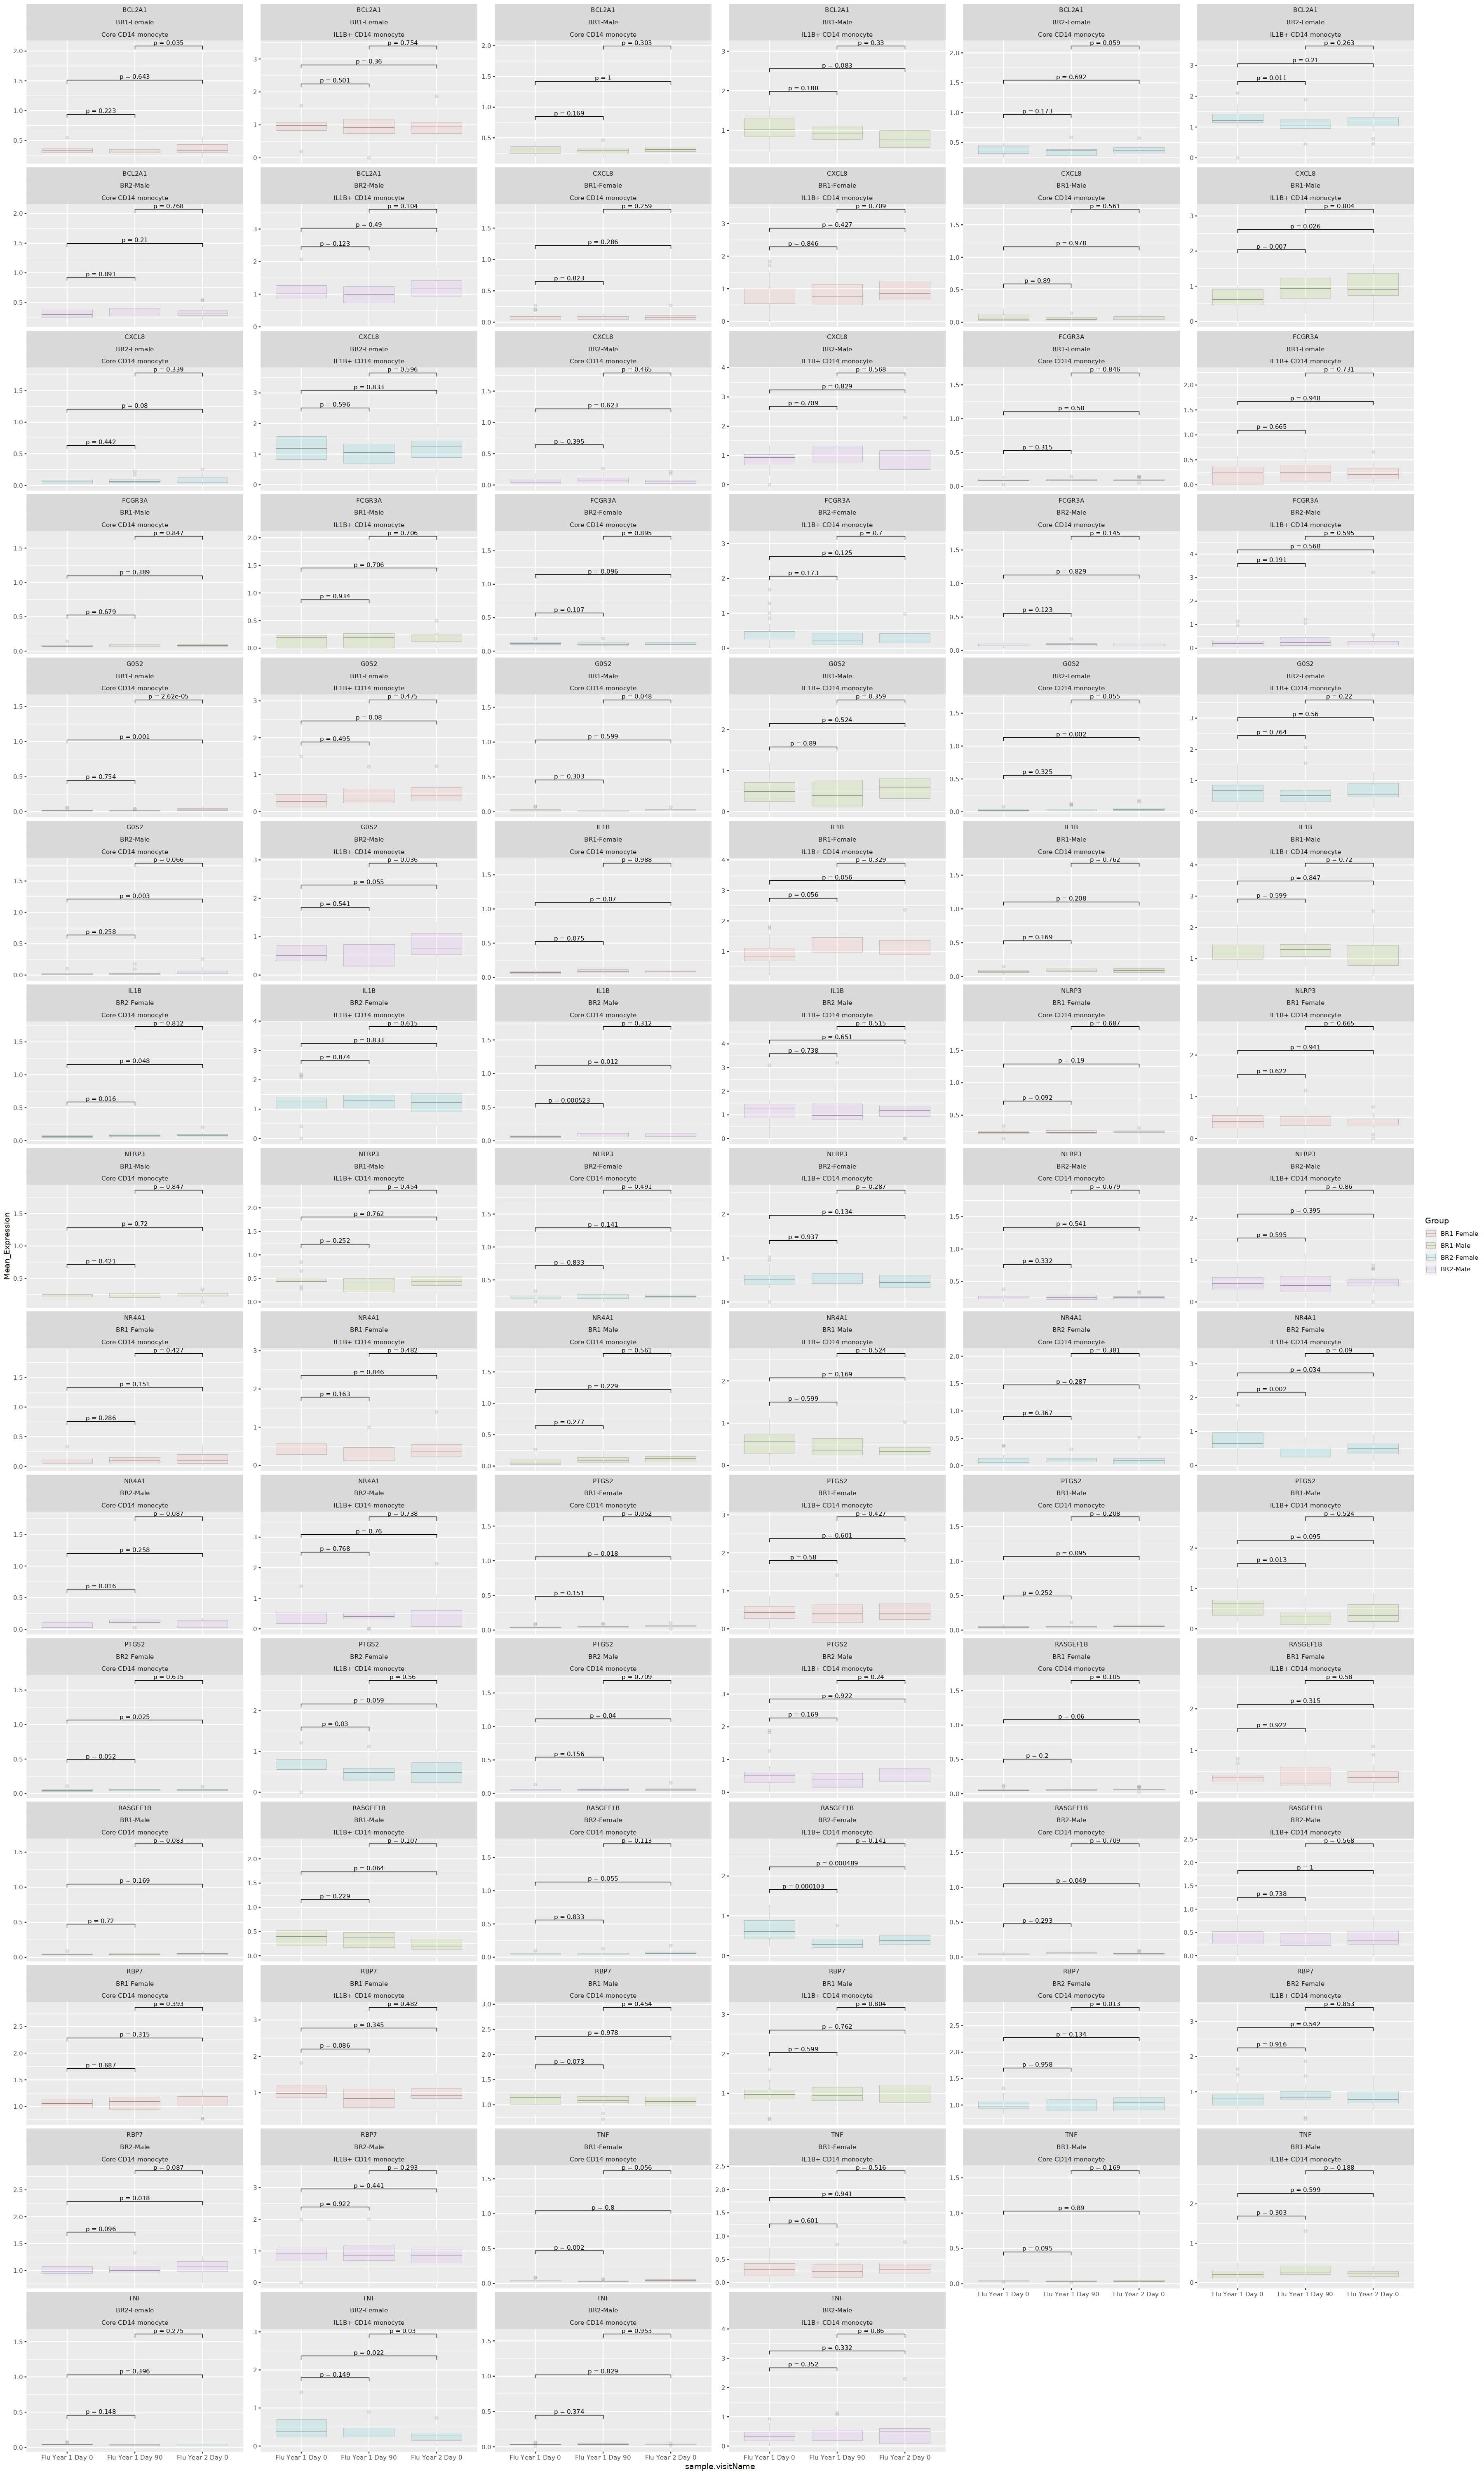

In [36]:
options(repr.plot.width = 30, repr.plot.height = 50)

ggplot(mean_df_filtered ,
       aes(x = sample.visitName, y = Mean_Expression, fill = Group)) +
  geom_boxplot(position = position_dodge(width = 0.9),size=0.05,alpha=0.1) +
facet_wrap(~Gene+Group+AIFI_L3,scale='free_y',
            ncol=6)  +   
stat_pvalue_manual(STAT_res, ,
    step.increase = 0,
                   label = "p = {p}", 
                   size=3)

In [16]:
mean_df_filtered_sub<-mean_df_filtered %>% filter(AIFI_L3=='Core CD14 monocyte',Gene=='CXCL8')

In [ ]:
pwc <- mean_df_filtered_sub %>%
  group_by(Group,subject.biologicalSex,AIFI_L3,Gene)  %>% arrange(subject.subjectGuid, sample.visitName)%>%
  wilcox_test(Mean_Expression ~ sample.visitName,paired=TRUE)%>% add_xy_position(x = "sample.visitName", group = "Group")


In [15]:
options(repr.plot.width = 15, repr.plot.height = 8)

ggboxplot(
  mean_df_filtered_sub, x = "sample.visitName", y = "Mean_Expression", 
  color = "Group", palette = c("#00AFBB", "#00AFBB", "#E7B800","#E7B800")
  )+facet_wrap(~subject.biologicalSex+AIFI_L3+Gene,scale='free',ncol=6)+
  stat_pvalue_manual(
    pwc, color = "Group", step.group.by = "Group",
    tip.length = 0.01, step.increase = 0.2
    )

ERROR: Error in eval(expr, envir, enclos): object 'mean_df_filtered_sub' not found


In [20]:
mean_df_filtered_sub

pbmc_sample_id Gene  AIFI_L3            Mean_Expression X.2 X.1 X  
1   PB00002-01     CXCL8 Core CD14 monocyte 0.14065460       2   2   2 
2   PB00003-01     CXCL8 Core CD14 monocyte 0.11651613       3   3   3 
3   PB00004-01     CXCL8 Core CD14 monocyte 0.20631158       4   4   4 
4   PB00006-01     CXCL8 Core CD14 monocyte 0.09381256       5   5   5 
5   PB00010-02     CXCL8 Core CD14 monocyte 0.03562793       6   6   6 
6   PB00012-01     CXCL8 Core CD14 monocyte 0.14113727       7   7   7 
7   PB00014-01     CXCL8 Core CD14 monocyte 0.12751660       8   8   8 
8   PB00015-01     CXCL8 Core CD14 monocyte 0.09861803       9   9   9 
9   PB00016-01     CXCL8 Core CD14 monocyte 0.07990847      10  10  10 
10  PB00022-01     CXCL8 Core CD14 monocyte 0.06317288      11  11  11 
11  PB00023-05     CXCL8 Core CD14 monocyte 0.02059650      12  12  12 
12  PB00025-04     CXCL8 Core CD14 monocyte 0.02064275      13  13  13 
13  PB00026-05     CXCL8 Core CD14 monocyte 0.04062664      14  14  14 
14  PB00030-02     CXCL8 Core CD14 monocyte 0.03889075      15  15  15 
15  PB00031-05     CXCL8 Core CD14 monocyte 0.04893874      16  16  16 
16  PB00041-01     CXCL8 Core CD14 monocyte 0.01944798      17  17  17 
17  PB00334-01     CXCL8 Core CD14 monocyte 0.04593351      19  19  19 
18  PB00338-01     CXCL8 Core CD14 monocyte 0.19478341      20  20  20 
19  PB00339-01     CXCL8 Core CD14 monocyte 0.04228517      21  21  21 
20  PB00341-01     CXCL8 Core CD14 monocyte 0.26180791      22  22  22 
21  PB00342-01     CXCL8 Core CD14 monocyte 0.18571723      23  23  23 
22  PB00345-01     CXCL8 Core CD14 monocyte 0.03648064      24  24  24 
23  PB00347-01     CXCL8 Core CD14 monocyte 0.09360854      25  25  25 
24  PB00349-01     CXCL8 Core CD14 monocyte 0.03661197      26  26  26 
25  PB00350-01     CXCL8 Core CD14 monocyte 0.03947945      27  27  27 
26  PB00352-04     CXCL8 Core CD14 monocyte 0.08367831      28  28  28 
27  PB00353-04     CXCL8 Core CD14 monocyte 0.06197853      29  29  29 
28  PB00356-01     CXCL8 Core CD14 monocyte 0.06064676      30  30  30 
29  PB00357-01     CXCL8 Core CD14 monocyte 0.02841604      31  31  31 
30  PB00362-01     CXCL8 Core CD14 monocyte 0.09336462      32  32  32 
⋮   ⋮              ⋮     ⋮                  ⋮               ⋮   ⋮   ⋮  
217 PB02498-001    CXCL8 Core CD14 monocyte 0.061726473     689 689 597
218 PB02499-001    CXCL8 Core CD14 monocyte 0.063853176     690 690 598
219 PB02500-001    CXCL8 Core CD14 monocyte 0.114505603     691 691 599
220 PB02502-001    CXCL8 Core CD14 monocyte 0.024846538     693 693 601
221 PB02503-001    CXCL8 Core CD14 monocyte 0.015415559     694 694 602
222 PB02506-001    CXCL8 Core CD14 monocyte 0.074711659     697 697 605
223 PB02508-001    CXCL8 Core CD14 monocyte 0.022382907     699 699 607
224 PB02511-001    CXCL8 Core CD14 monocyte 0.077733736     702 702 610
225 PB02515-002    CXCL8 Core CD14 monocyte 0.009465578     706 706 614
226 PB02516-001    CXCL8 Core CD14 monocyte 0.067689328     707 707 615
227 PB02517-001    CXCL8 Core CD14 monocyte 0.091365541     708 708 616
228 PB02522-002    CXCL8 Core CD14 monocyte 0.009841041     713 713 621
229 PB02523-001    CXCL8 Core CD14 monocyte 0.223107530     714 714 622
230 PB02527-002    CXCL8 Core CD14 monocyte 0.183219003     718 718 626
231 PB02529-001    CXCL8 Core CD14 monocyte 0.067496398     720 720 628
232 PB02530-001    CXCL8 Core CD14 monocyte 0.060116331     721 721 629
233 PB02532-001    CXCL8 Core CD14 monocyte 0.118358572     723 723 631
234 PB02535-001    CXCL8 Core CD14 monocyte 0.071034567     726 726 634
235 PB02536-001    CXCL8 Core CD14 monocyte 0.214256728     727 727 635
236 PB02540-001    CXCL8 Core CD14 monocyte 0.072981929     730 730 638
237 PB02546-002    CXCL8 Core CD14 monocyte 0.032489432     736 736 644
238 PB02547-001    CXCL8 Core CD14 monocyte 0.179351531     737 737 645
239 PB02548-001    CXCL8 Core CD14 monocyte 0.091352128     738 738 646
240 PB02552-001    CXCL8 Core CD14 monocyte 

Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


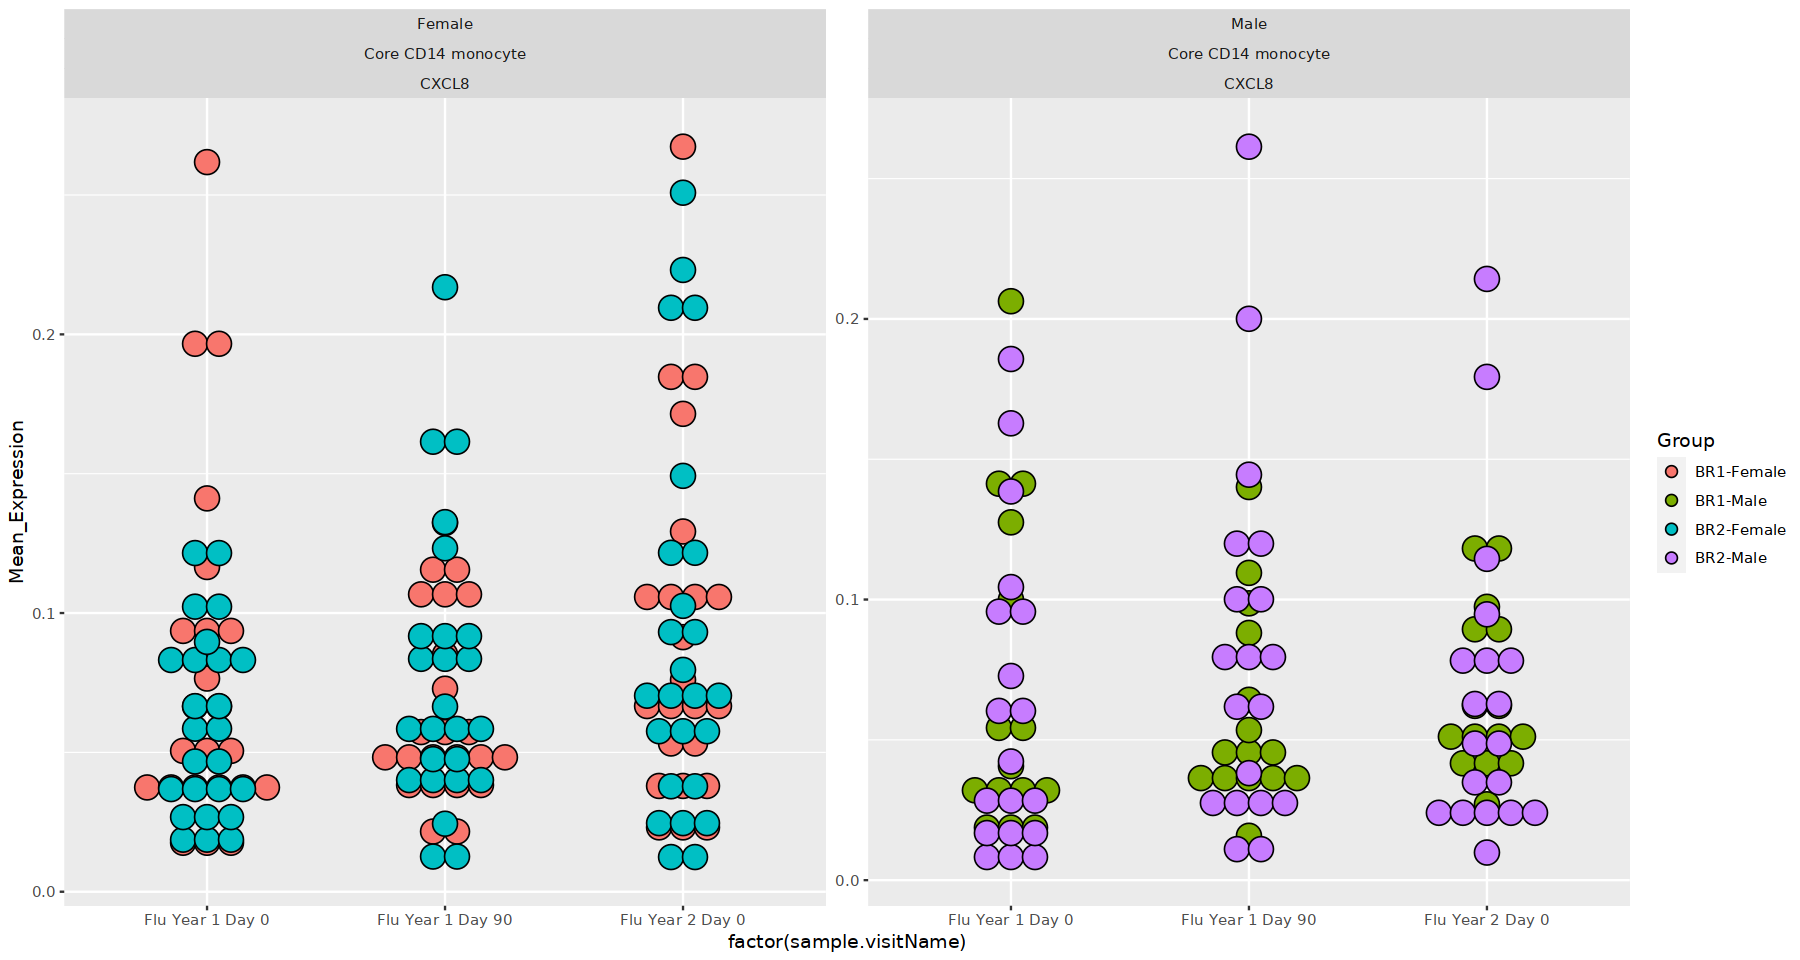

In [26]:
ggplot(as.data.frame(mean_df_filtered_sub), aes(x = factor(sample.visitName), y = Mean_Expression, 
  fill = Group)) +
  geom_dotplot(binaxis = "y", stackdir = "center")+facet_wrap(~subject.biologicalSex+AIFI_L3+Gene,scale='free',ncol=6)

In [30]:
options(repr.plot.width = 15, repr.plot.height = 30)

ggplot(mean_df %>% 
       filter(!sample.visitName %in% c('Flu Year 1 Day 7','Flu Year 2 Day 7',
                                       'Flu Year 1 Stand-Alone','Flu Year 2 Day 90',
                                                   'Flu Year 2 Stand-Alone',
                                                   'Flu Year 3 Stand-Alone'))%>% 
       filter(AIFI_L3 %in% c('IL1B+ CD14 monocyte')), 
       aes(x = sample.visitName, y = Mean_Expression, fill = Group)) +
  geom_dotplot() +
  stat_summary(
    fun.y = median,
    geom = 'line',
    aes(group =Group, colour = Group),#position = position_dodge(width = 0.9)
     )+theme_bw(base_size=15)+ 
theme(axis.text.x = element_text(angle = 90, 
                                 vjust = 0.5, 
                                 hjust=1))+
facet_wrap(~Gene+subject.biologicalSex,scale='free_y',
            ncol=2)

Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.
Warning message:
“The following aesthetics were dropped during statistical transformation: y
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?”
Warning message:
“The following aesthetics were dropped during statistical transformation: y
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?”
Warning message:
“The following aesthetics were dropped during statistical transformation: y
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?”
Warning message:
“The following aesthetics were dropped d